# **Letter classification study using the Random Forest model**

## **Read dataset**

This part contains the functions to read the dataset saved in the ".npy" files to use it in the random forest classifier. The ".npy" files are generated by the bash script called ./init.sh

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

from sklearn.externals import joblib
import string

In [2]:
# Class used in the classification

class Letter:
    def __init__(self, data, target):
        self.target = target
        self.width  = int(np.sqrt(len(data)))
        self.image  = data.reshape(self.width, self.width)
        self.features = {'var' : 0,
                         'std' : 0,
                         'mean_grad_M' : 0,
                         'std_grad_M'  : 0,
                         'mean_grad_D' : 0,
                         'std_grad_D'  : 0,
                         'mean_PC_X'   : 0,
                         'std_PC_X'    : 0,
                         'active_PC_X' : 0,
                         'mean_PC_Y'   : 0,
                         'std_PC_Y'    : 0,
                         'active_PC_Y' : 0}
        self.computeFeatures()
    
    def computeFeatures(self):
        # Feature computation
        mag, ang = sobel(self.image)
        pcx, pcy = pixel_count(self.image)
        
        self.features['var'] = np.var(self.image)
        self.features['std'] = np.std(self.image)
        self.features['mean_grad_M'] = np.mean(mag)
        self.features['std_grad_M'] =  np.std(mag)
        self.features['mean_grad_D'] = np.mean(ang)
        self.features['std_grad_D'] =  np.std(ang)
        self.features['mean_PC_X'] =   np.mean(pcx)
        self.features['std_PC_X'] =    np.std(pcx)
        self.features['active_PC_X'] = np.count_nonzero(pcx)
        self.features['mean_PC_Y'] =   np.mean(pcy)
        self.features['std_PC_Y'] =    np.std(pcy)
        self.features['active_PC_Y'] = np.count_nonzero(pcy) 
  
    def __print__(self):
        print("Letter target: "+str(self.target))
        print("Letter features:")
        print(self.features)
        print("Letter image:")
        plt.gray()
        plt.matshow(self.image) 
        plt.show()

In [3]:
# Support function to calculate some values of the features
def sobel(image):
    w = len(image)
    kernel_x = np.array([ [ 1, 0,-1],
                          [ 2, 0,-2],
                          [ 1, 0,-1] ])

    kernel_y = np.array([ [ 1, 2, 1],
                          [ 0, 0, 0],
                          [-1,-2,-1] ])
    
    grad_x = np.zeros([w - 2, w - 2])
    grad_y = np.zeros([w - 2, w - 2])
    
    for i in range(w - 2):
        for j in range(w - 2):
            grad_x[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_x))
            grad_y[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_y))
            if grad_x[i, j] == 0:
                grad_x[i, j] = 0.000001 
    
    mag = np.sqrt(grad_y ** 2 + grad_x ** 2)
    ang = np.arctan(grad_y / (grad_x + np.finfo(float).eps))
  
    # Gradient computation
  
    return [mag,ang]

# Support function to calculate some values of the features
def pixel_count(image):
    pc_x = np.zeros(len(image))
    pc_y = np.zeros(len(image))
  
    # Pixel count computation
    for i in range(len(image)):
        pc_x[i] = np.count_nonzero(image[i, :])
        pc_y[i] = np.count_nonzero(image[:, i])

    return [pc_x, pc_y]


In [4]:
# Class dataset with the objects letters
class Dataset:
    def __init__(self, array, length):  
        self.array = array
        self.length = length
        self.letters = []
        self.letters = self.createLetters()
        self.raw_features = [[float(f) for f in dig.features.values()] for dig in self.letters]
        self.raw_targets  = [[self.letters[i].target] for i in range(self.length)]
  
    def createLetters(self):
        letters = []
        for row in self.array:
            letters.append(Letter(np.array(row[:-1]), row[-1]))
        return letters

## **Generate datasets**

This part contains the generation of information to make the test of the application


In [5]:
# n : percent of the number of lines in the data base use as array set
def load_data_set(array, n):
    dataset = Dataset(array[:int(n * len(array))], int(n * len(array)))
    
    return dataset

In [6]:
%%time

#Load the database (.npy) files 
img_array_test = np.load('./../../test.npy')


CPU times: user 650 µs, sys: 65 ms, total: 65.6 ms
Wall time: 1.24 s


In [7]:
%%time 

print("Creating testing dataset")
print("Number of the lines in the test dataset: " + str(len(img_array_test)))
testing_set = load_data_set(img_array_test, 1)
print ("Number of the lines in the test dataset: " + str(testing_set.length))
print ("\nFinished creating test dataset\n")

Creating testing dataset
Number of the lines in the test dataset: 20800
Number of the lines in the test dataset: 20800

Finished creating test dataset

CPU times: user 3min 40s, sys: 613 ms, total: 3min 40s
Wall time: 3min 40s


In [8]:
'''
for i in range(0,5):
    validation_set.digits[i].__print__()
'''

'\nfor i in range(0,5):\n    validation_set.digits[i].__print__()\n'

In [9]:
# Function to convert the object into an array

def cvt_obj_nparray(dataset):
    X = np.zeros((dataset.length, 12))
    Y = np.zeros((dataset.length,))
    for i, letter in enumerate(dataset.letters):
        Y[i] = letter.target
        for j, feature in enumerate(letter.features):
            X[i, j] = letter.features[feature]
    return X, Y

In [10]:
%%time

#The X_dataset and Y_dataset are the lists used in the classifier
print("Creating X_dataset and Y_dataset")
X_test, Y_test = cvt_obj_nparray(testing_set)
print("Finished X_dataset and Y_dataset\n")

Creating X_dataset and Y_dataset
Finished X_dataset and Y_dataset

CPU times: user 97 ms, sys: 8.01 ms, total: 105 ms
Wall time: 98.1 ms


# **Random Forest algorithm**

In [11]:
# This function is the function that plots the confusion matrix only to better visualize the results

def plot_confusion_matrix(clf, data_x, data_y):
    classes = string.ascii_uppercase
    
    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.figure(figsize=(15,12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Load classifier

In [14]:
# load first knn classifier
first_classifier = './randomForest_classifier.sav'
randomForest_classificator = joblib.load(first_classifier)


In [15]:
# Information of the classifier

randomForest_classificator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
# load best knn classifier
best_classifier = './best_randomForest_classifier.sav'
best_randomForest_classificator = joblib.load(best_classifier)

In [17]:
# Information of the best classifier

best_randomForest_classificator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
result = randomForest_classificator.score(X_test, Y_test)
print(str(round(result * 100, 3)) + "%")

43.587%


In [19]:
best_result = best_randomForest_classificator.score(X_test, Y_test)
print(str(round(best_result * 100, 3)) + "%")

47.538%


In [20]:
# Compute prediction accuracy on testing set
def test_randomForestModel(clf, nom):
    predicted = clf.predict(X_test)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_test)) + " images")
    
    plot_confusion_matrix(clf, X_test, Y_test)
    plt.title('Test confusion matrix: accuracy of ' + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%, used " + str(len(X_test)) + " images")
    plt.savefig(nom)
    #plt.show()

The accuracy for test database is: 43.587%
Using: 20800 images


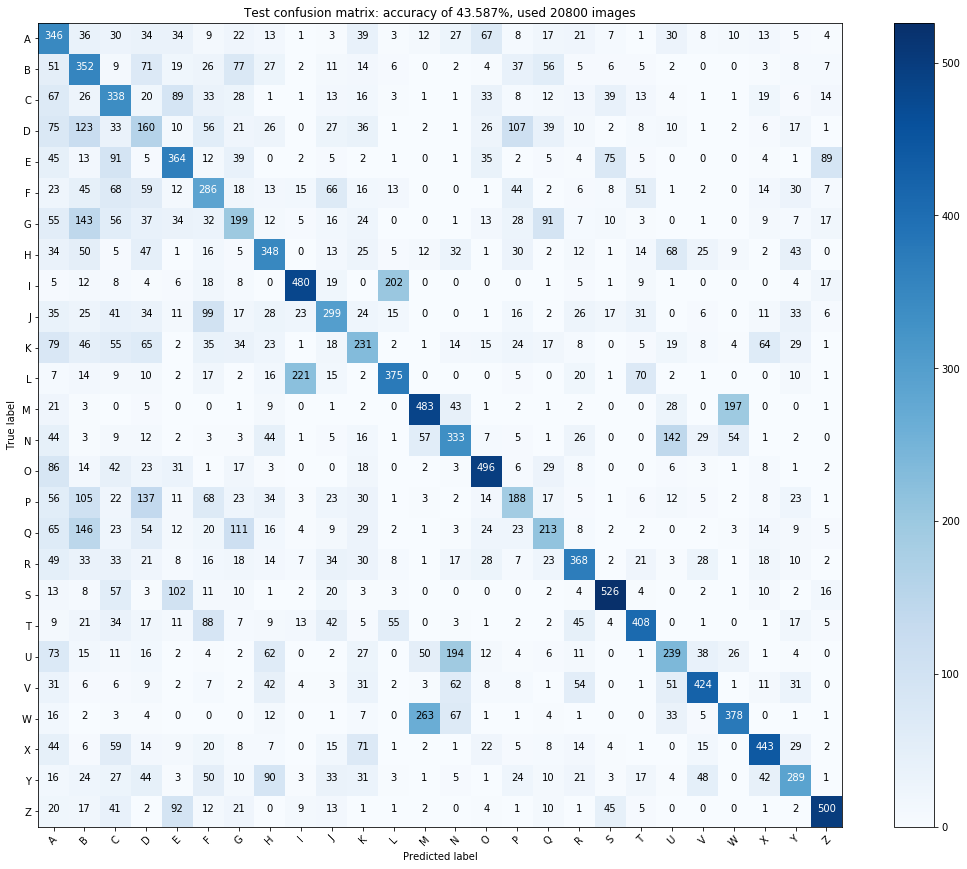

In [23]:
test_randomForestModel(randomForest_classificator, './test_simple_classifier')

The accuracy for test database is: 47.538%
Using: 20800 images


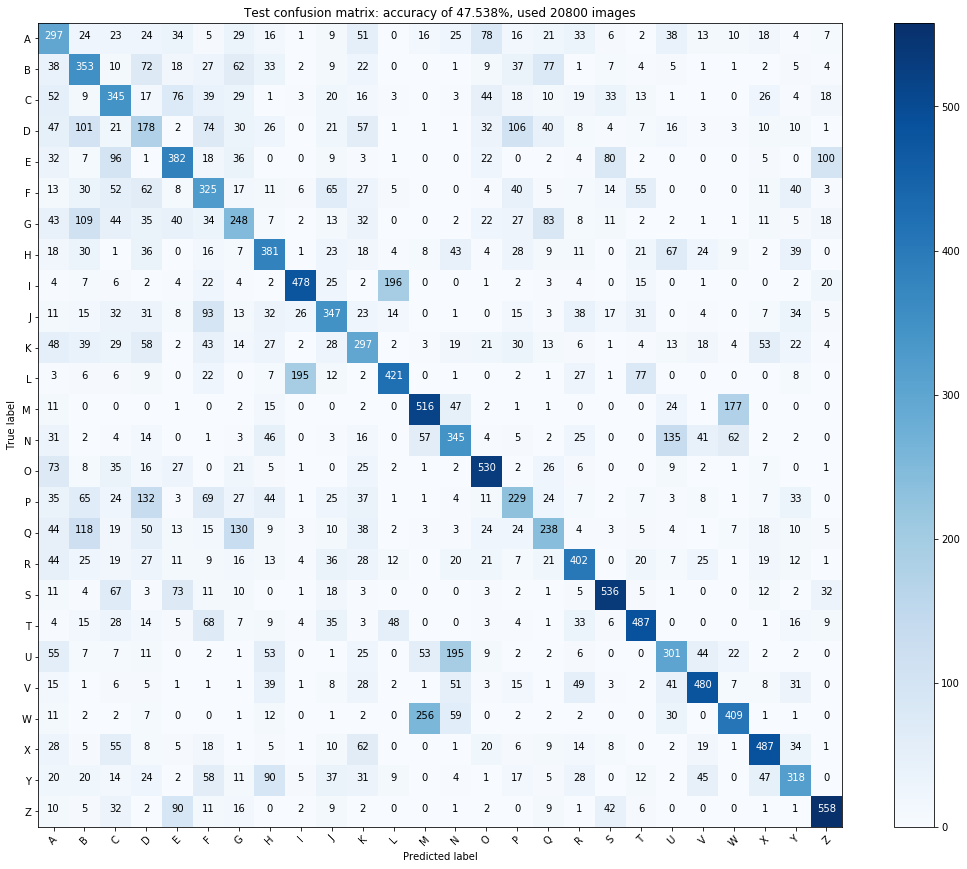

In [24]:
test_randomForestModel(best_randomForest_classificator, './test_best_classifier')

# APPLICATION

In [25]:
%%time

#Load the database (.npy) files 
img_array_photos = np.load('./../photos/test_photos.npy')

CPU times: user 13.5 ms, sys: 44.2 ms, total: 57.7 ms
Wall time: 1.35 s


In [26]:
%%time 

print("Creating validation dataset...")
print("Number of the lines in the validation dataset: " + str(len(img_array_photos)))
photos_set = load_data_set(img_array_photos, 1)
print ("Number of the lines in the validation dataset: " + str(photos_set.length))
print ("\nFinished creating validation dataset\n")

Creating validation dataset...
Number of the lines in the validation dataset: 18720
Number of the lines in the validation dataset: 18720

Finished creating validation dataset

CPU times: user 3min 51s, sys: 336 ms, total: 3min 51s
Wall time: 3min 51s


In [27]:
%%time

#The X_dataset and Y_dataset are the lists used in the classifier
print("Creating X_dataset and Y_dataset")
X_photos, Y_photos = cvt_obj_nparray(photos_set)
print("Finished X_dataset and Y_dataset\n")

Creating X_dataset and Y_dataset
Finished X_dataset and Y_dataset

CPU times: user 94.8 ms, sys: 25 µs, total: 94.9 ms
Wall time: 90 ms


Letter target: 25.0
Letter features:
{'std_grad_M': 336.04623132165415, 'mean_grad_D': -0.046451434200088855, 'std_grad_D': 0.5591279218940906, 'var': 7264.07041336943, 'active_PC_X': 17, 'active_PC_Y': 18, 'std': 85.22951609254525, 'std_PC_X': 6.127368346781745, 'std_PC_Y': 5.336029824290179, 'mean_grad_M': 193.72192661746666, 'mean_PC_Y': 5.75, 'mean_PC_X': 5.75}
Letter image:


<Figure size 432x288 with 0 Axes>

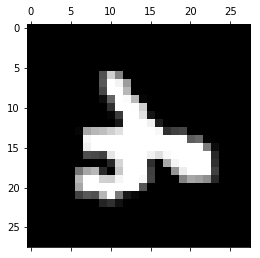

Letter target: 16.0
Letter features:
{'std_grad_M': 350.4524143104736, 'mean_grad_D': -0.04246440417006841, 'std_grad_D': 0.5967402983683898, 'var': 7316.785870470638, 'active_PC_X': 17, 'active_PC_Y': 21, 'std': 85.53821292539749, 'std_PC_X': 6.397145409302113, 'std_PC_Y': 4.659311502085838, 'mean_grad_M': 216.67927920705284, 'mean_PC_Y': 5.928571428571429, 'mean_PC_X': 5.928571428571429}
Letter image:


<Figure size 432x288 with 0 Axes>

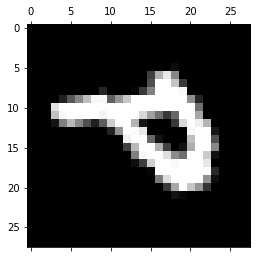

Letter target: 16.0
Letter features:
{'std_grad_M': 351.39954991318984, 'mean_grad_D': -0.11255754534924052, 'std_grad_D': 0.5057815950033056, 'var': 7289.1319355867345, 'active_PC_X': 19, 'active_PC_Y': 18, 'std': 85.37641322746425, 'std_PC_X': 4.69041575982343, 'std_PC_Y': 5.694608979427072, 'mean_grad_M': 215.7894439759705, 'mean_PC_Y': 6.0, 'mean_PC_X': 6.0}
Letter image:


<Figure size 432x288 with 0 Axes>

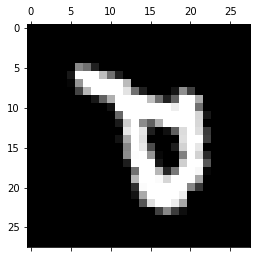

Letter target: 18.0
Letter features:
{'std_grad_M': 304.6107966427508, 'mean_grad_D': -0.053093572929846844, 'std_grad_D': 0.47629091833769444, 'var': 6813.553843125262, 'active_PC_X': 14, 'active_PC_Y': 18, 'std': 82.54425384680185, 'std_PC_X': 5.783840084446404, 'std_PC_Y': 4.5930015529396595, 'mean_grad_M': 151.48611696705902, 'mean_PC_Y': 4.892857142857143, 'mean_PC_X': 4.892857142857143}
Letter image:


<Figure size 432x288 with 0 Axes>

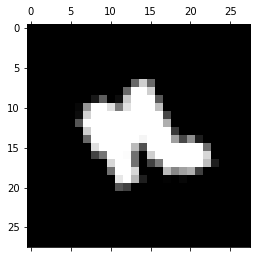

Letter target: 1.0
Letter features:
{'std_grad_M': 375.3778363535717, 'mean_grad_D': -0.06190555993212862, 'std_grad_D': 0.6917823362516236, 'var': 7696.823118947834, 'active_PC_X': 20, 'active_PC_Y': 24, 'std': 87.73154004659803, 'std_PC_X': 5.316512590265256, 'std_PC_Y': 4.1637404690827635, 'mean_grad_M': 268.7328155033496, 'mean_PC_Y': 6.857142857142857, 'mean_PC_X': 6.857142857142857}
Letter image:


<Figure size 432x288 with 0 Axes>

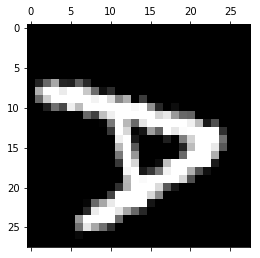

In [28]:
for i in range(0,5):
    photos_set.letters[i].__print__()


In [29]:
# Compute prediction accuracy on testing set
def photos_randomForestModel(clf, nom):
    predicted = clf.predict(X_photos)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_photos, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_photos)) + " images")
    
    plot_confusion_matrix(clf, X_photos, Y_photos)
    plt.title('Photos confusion matrix: accuracy of ' + str(round((accuracy_score(Y_photos, predicted) * 100), 3)) + "%, used " + str(len(X_photos)) + " images")
    plt.savefig(nom)

The accuracy for test database is: 4.434%
Using: 18720 images


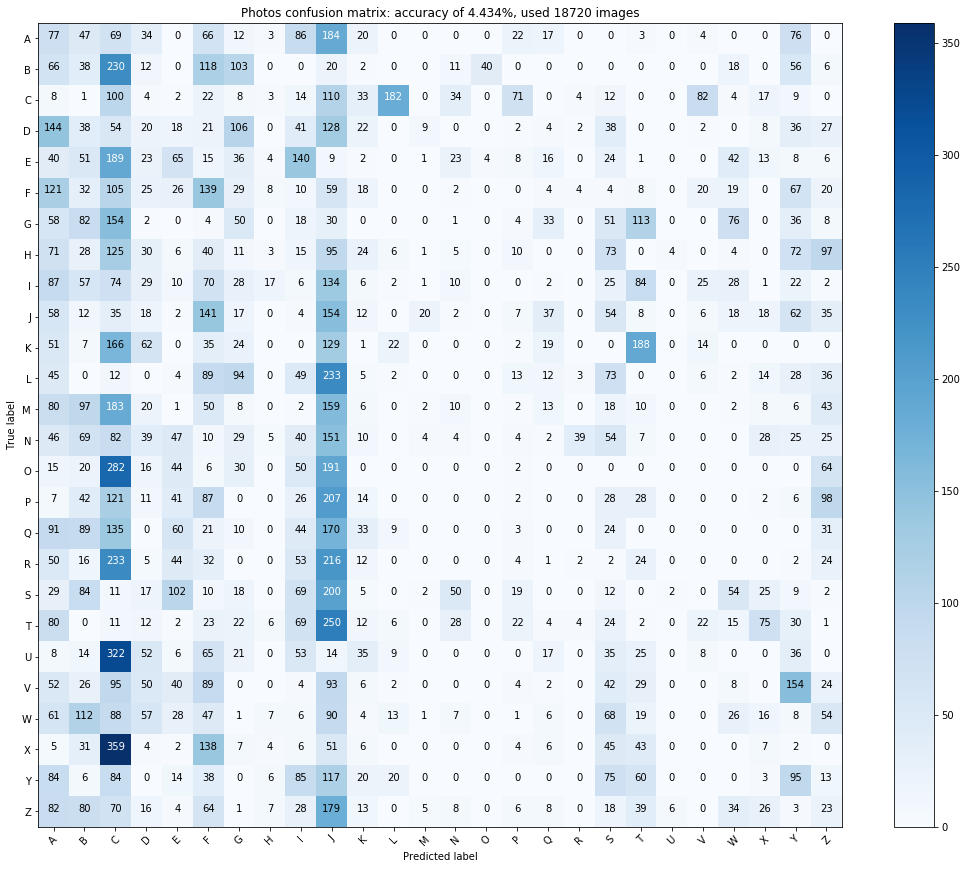

In [30]:
photos_randomForestModel(randomForest_classificator, './photos_simple_classifier')

The accuracy for test database is: 6.464%
Using: 18720 images


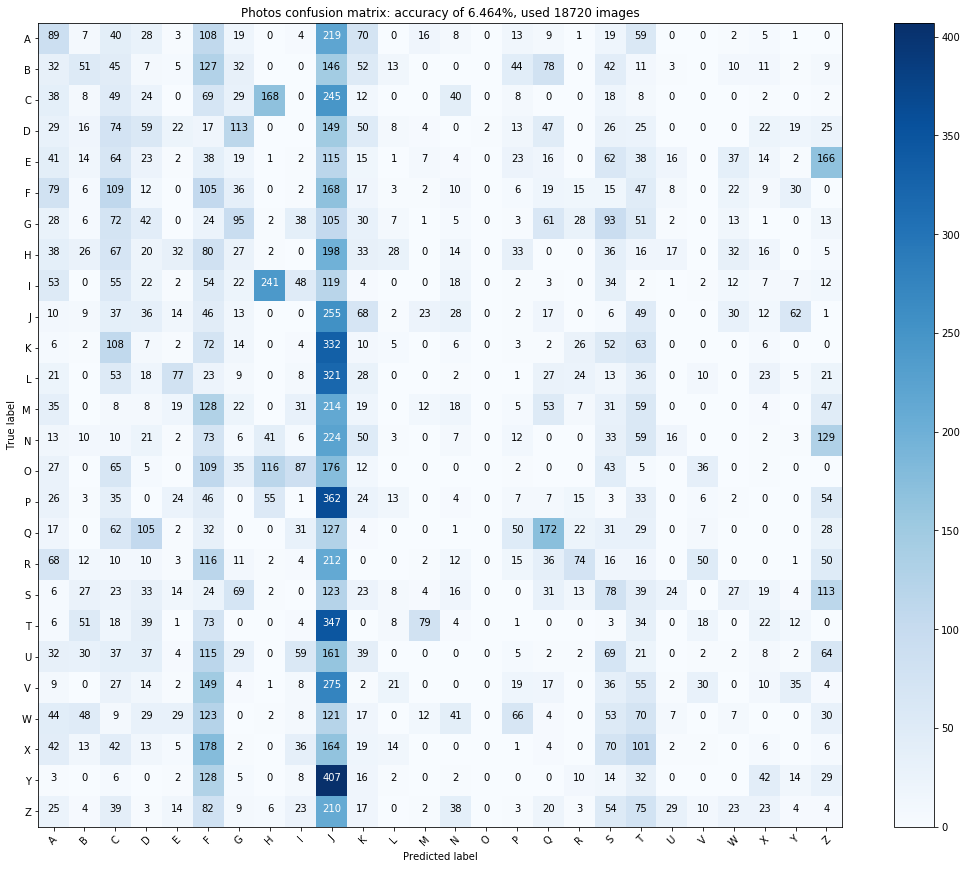

In [31]:
photos_randomForestModel(best_randomForest_classificator, './photos_best_classifier')